**Cognitive Load Estimation**

Imports

In [43]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

I'll start by visualizing and analyzing just one session to understand how I can draw insights from raw json data

In [44]:
with open("sample_mouse_data.json", "r") as f:
    mouse_data = json.load(f)

In [45]:
df = pd.DataFrame(mouse_data['mouseMoves'])
df['t'] = pd.to_datetime(df['t'], unit='ms')  
df.head()

,x,y,t
0,671,302,2025-07-10 08:00:02.224
1,694,281,2025-07-10 08:00:02.233
2,736,249,2025-07-10 08:00:02.250
3,783,225,2025-07-10 08:00:02.266
4,830,209,2025-07-10 08:00:02.282


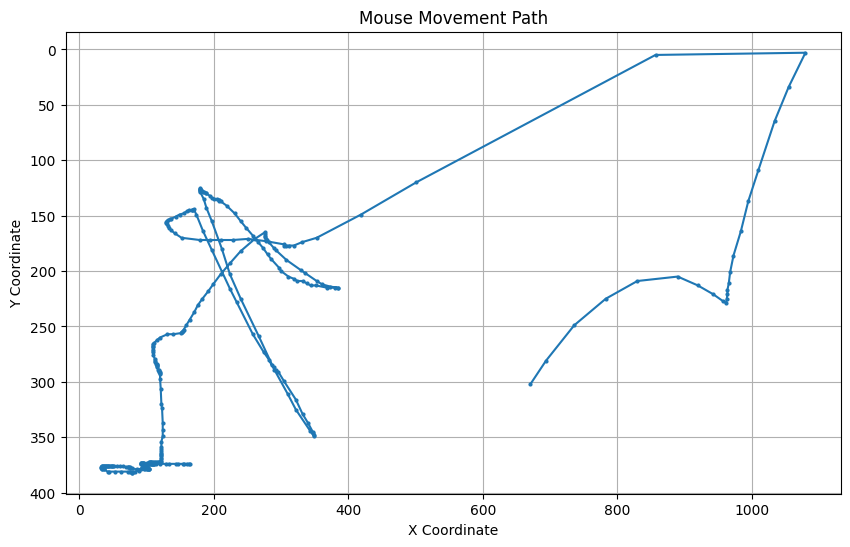

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(df['x'], df['y'], marker='o', markersize=2, linestyle='-')
plt.gca().invert_yaxis()  
plt.title("Mouse Movement Path")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

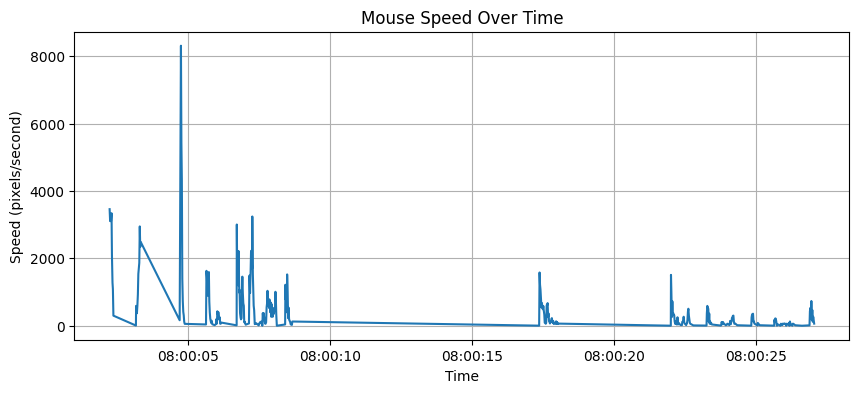

In [47]:
df['time_diff'] = df['t'].diff().dt.total_seconds()
df['distance'] = np.sqrt(df['x'].diff()**2 + df['y'].diff()**2)
df['speed'] = df['distance'] / df['time_diff']

plt.figure(figsize=(10, 4))
plt.plot(df['t'], df['speed'])
plt.title("Mouse Speed Over Time")
plt.ylabel("Speed (pixels/second)")
plt.xlabel("Time")
plt.grid(True)
plt.show()

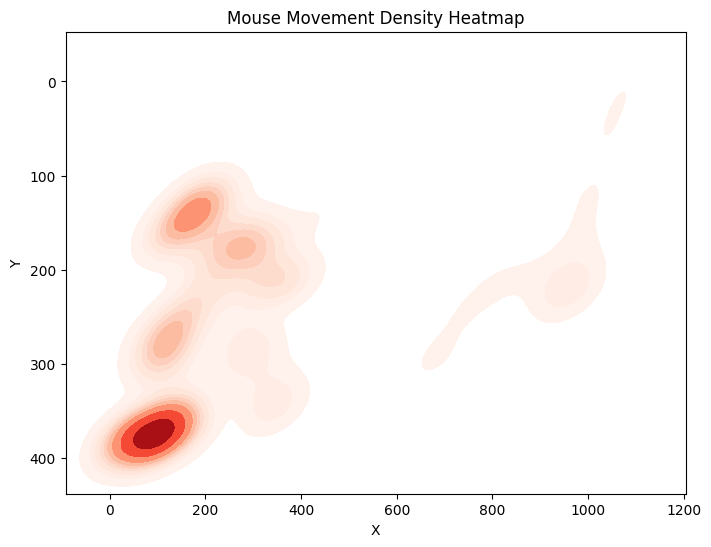

In [48]:
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df['x'], y=df['y'], fill=True, cmap="Reds", bw_adjust=0.5)
plt.gca().invert_yaxis()
plt.title("Mouse Movement Density Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Now lets analyze multiple sessions together

In [49]:
with open("backend/sessions.json", "r") as f:
    sessions = json.load(f)

session_dfs_mouse_data = {}
for session_id, session_data in sessions.items():
    if "mouseMoves" in session_data:
        df = pd.DataFrame(session_data["mouseMoves"])
        df["session_id"] = session_id
        session_dfs_mouse_data[session_id] = df

In [50]:
mouse_df = pd.concat(session_dfs_mouse_data, ignore_index=True)

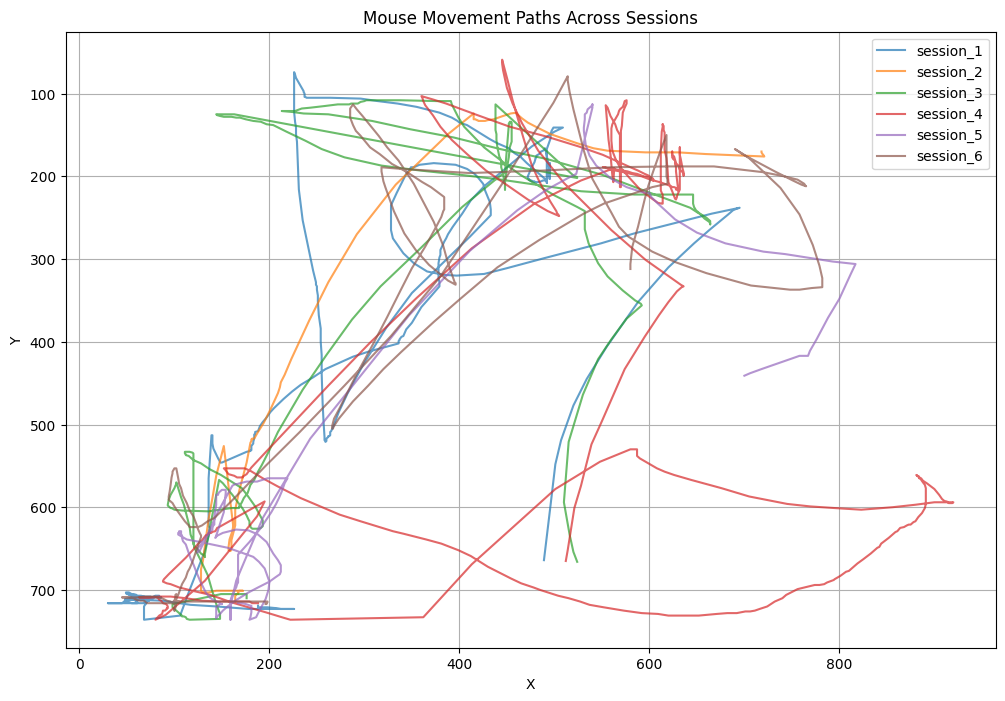

In [51]:
plt.figure(figsize=(12, 8))

for session_id, group in mouse_df.groupby("session_id"):
    plt.plot(group["x"], group["y"], label=session_id, alpha=0.7)

plt.gca().invert_yaxis() 
plt.title("Mouse Movement Paths Across Sessions")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

Some insights:  
1- Lines are more concentrated in the upper left corner where the questions are  
2- There is a line stretched toward bottom right or right in general, in almost all the sessions that suggests that most people tried to increase the text box size even when they didn't write anything in it.

Predicting the cognitive load using available data

In [52]:
with open('./backend/sessions.json', 'r') as f:
    sessions = json.load(f)

session_list = []
for session_id, session in sessions.items():
    flattened = {
        "session_id": session_id,
        "startTime": session.get("startTime"),
        "endTime": session.get("endTime"),
        "duration": session.get("endTime", 0) - session.get("startTime", 0),
        "rating": session.get("rating"),
        "age": session.get("age"),
        "answer": session.get("answer"),
        "mouseMoveCount": len(session.get("mouseMoves", [])),
        "scrollCount": len(session.get("scrolls", [])),
        "clickCount": len(session.get("clicks", [])),
        "keystrokeCount": len(session.get("keyStrokes", []))
    }
    session_list.append(flattened)

df = pd.DataFrame(session_list)

df["startTime"] = pd.to_datetime(df["startTime"], unit="ms")
df["endTime"] = pd.to_datetime(df["endTime"], unit="ms")

df.head()

,session_id,startTime,endTime,duration,rating,age,answer,mouseMoveCount,scrollCount,clickCount,keystrokeCount
0,session_1,2025-07-19 08:40:44.933,2025-07-19 08:41:47.285,62352,2,20,villagers are not abandoning the tradition eve...,494,15,18,82
1,session_2,2025-07-19 08:43:09.994,2025-07-19 08:43:21.286,11292,4,17,,138,6,3,1
2,session_3,2025-07-19 08:44:09.158,2025-07-19 08:44:35.373,26215,5,21,,321,2,17,1
3,session_4,2025-07-19 08:45:00.410,2025-07-19 08:46:46.130,105720,3,30,it is a story about a costal village where peo...,523,4,25,197
4,session_5,2025-07-19 08:46:55.089,2025-07-19 08:47:19.992,24903,4,14,,237,3,5,11


In [53]:
df = df.drop(columns=['startTime', 'endTime', 'answer'])

In [54]:
def compute_mouse_speed(mouse_moves):
    if len(mouse_moves) < 2:
        return 0
    total_distance = 0
    total_time = mouse_moves[-1]['t'] - mouse_moves[0]['t']
    for i in range(1, len(mouse_moves)):
        dx = mouse_moves[i]['x'] - mouse_moves[i-1]['x']
        dy = mouse_moves[i]['y'] - mouse_moves[i-1]['y']
        total_distance += (dx**2 + dy**2)**0.5
    return total_distance / (total_time / 1000 + 1e-6)  

def compute_scroll_range(scrolls):
    if not scrolls:
        return 0
    ys = [s['y'] for s in scrolls]
    return max(ys) - min(ys)

In [55]:
mouse_speeds = []
scroll_ranges = []
cognitive_load = []

for idx, row in df.iterrows():
    session_id = row['session_id']
    session = sessions[session_id]
    
    speed = compute_mouse_speed(session.get('mouseMoves', []))
    scroll = compute_scroll_range(session.get('scrolls', []))
    
    mouse_speeds.append(speed)
    scroll_ranges.append(scroll)
    label = 'high' if int(row['rating']) >= 5 else 'low'
    cognitive_load.append(label)


df['mouse_speed'] = mouse_speeds
df['scroll_range'] = scroll_ranges
df['cognitive_load'] = cognitive_load

In [56]:
df = df.drop(columns = ['session_id'])

In [57]:
df.head()

,duration,rating,age,mouseMoveCount,scrollCount,clickCount,keystrokeCount,mouse_speed,scroll_range,cognitive_load
0,62352,2,20,494,15,18,82,61.481412,27.200001,low
1,11292,4,17,138,6,3,1,125.724995,16.800001,low
2,26215,5,21,321,2,17,1,158.756979,12.800001,high
3,105720,3,30,523,4,25,197,50.847169,48.000002,low
4,24903,4,14,237,3,5,11,96.186602,26.400001,low


I still need to collect enough samples to produce good enough results

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = df.drop(columns=['cognitive_load'])
y = df['cognitive_load']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.00      0.00      0.00         0
         low       1.00      0.50      0.67         2

    accuracy                           0.50         2
   macro avg       0.50      0.25      0.33         2
weighted avg       1.00      0.50      0.67         2



c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. 